In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import process, fuzz
from notnews import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Bashar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Bashar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
FILE_PATH = '../dataverse_files/'
PROCESSED_PATH = FILE_PATH + 'processed/'
PREDICT_NEWS = False

In [3]:
def split_text(s, n):
    pieces = str(s).split()
    return (' '.join(pieces[i:i+n]) for i in range(0, len(pieces), n))

In [4]:
def split_df(df, column, num=500):
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        w_generator = split_text(presplit, num)
        for word in w_generator:
            indexes.append(i)
            new_values.append(word)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

# Predicting Soft News probability
If PREDICT_NEWS = True then will run, this is very time consuming and should be run once
After which, the files generated should be saved to disk and preserved for future analysis
  as run time could take days depending on the number of records to analyze

In [5]:
if (PREDICT_NEWS):
    for file in os.listdir('../dataverse_files/'):
        if file.endswith(".csv"):
            print (file)
            dd = pd.read_csv( FILE_PATH + str(file), encoding = 'ISO-8859-1')
            print (f'Processing: {FILE_PATH + str(file)} ....')
            split_dd = split_df(dd, 'text')
            print (f'Finished splitting {FILE_PATH + str(file)} into chunks')
            soft_news_df = pred_soft_news_us(split_dd, col='text')
            print (f'Saving results for {FILE_PATH + str(file)}\n\n')
            soft_news_df.to_csv('{}soft_news_{}'.format(PROCESSED_PATH, file))
            os.rename(FILE_PATH+file, PROCESSED_PATH+file)

# Processing files

In [6]:
full_df = pd.DataFrame()

## Processing CNN Files

In [7]:
# Processing CNN files
processed_files = glob.glob(PROCESSED_PATH + 'soft_news_cnn*.csv')


for file in processed_files:
    news_df = pd.read_csv(file, encoding = 'ISO-8859-1')

    # Default to CNN and then get the index prior to splitting into mulit-records and assign all records
    #  to CNN International if the transcript contains CNN International in its text.
    news_df['channel.name'] = 'CNN'
    mod_list = news_df.loc[news_df['text'].str.contains('CNN INTERNATIONAL', case=False)]['Unnamed: 0'].tolist()    
    news_df.iloc[mod_list,2] = 'CNN International'
    
    # delete any outliers
    news_df.drop(news_df[news_df['year'] > 2100.0].index , axis=0, inplace=True)
    news_df.drop(news_df[news_df['year'] < 1900.0].index , axis=0, inplace=True)    

    # generate date field in format YYYY-MM-DD
    news_df['full_date'] = pd.to_datetime((news_df.year*10000+news_df.month*100+news_df.date),format='%Y%m%d')
    
    # cleaning up the dataframe and appending to the full dataframe
    news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]
    full_df = pd.concat([full_df, news_df], axis=0)
    

In [8]:
del news_df
full_df.shape

(2748284, 4)

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748284 entries, 0 to 1114473
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   channel.name       object        
 1   program.name       object        
 2   prob_soft_news_us  float64       
 3   full_date          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 104.8+ MB


## Processing NBC/MSNBC files
these files have different formats so we'll need to process individually

### MSNBC 2003-2014 data

In [10]:
news_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc--2003--2014.csv')
news_df.rename(columns={'Source':'channel.name', 'Show':'program.name'},inplace=True)
news_df['full_date'] = pd.to_datetime(news_df.Date)

# keeping only the required columns in the dataframe
news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]

### MSNBC 2010-2021 data

In [11]:
news2_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc-2010--2021.csv')
news2_df.drop('program.name', axis=1, inplace=True)
news2_df.rename(columns={'Source':'channel.name', 'show_name':'program.name'},inplace=True)
news2_df['full_date'] = pd.to_datetime(news2_df.air_date)

# keeping only the required columns in the dataframe
news2_df = news2_df[news2_df.columns[news2_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]


/Users/Bashar/opt/anaconda3/envs/nonconform/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
print (f'Size of 2003-2014 df: {news_df.shape}')
print (f'Size of 2010-2021 df: {news2_df.shape}')

Size of 2003-2014 df: (252433, 4)
Size of 2010-2021 df: (163122, 4)


Merging the 2 dataframes to see if there is any redundant records

In [13]:
news_df.merge(news2_df, how='outer', on=['channel.name','program.name','full_date', 'prob_soft_news_us'])

,channel.name,program.name,prob_soft_news_us,full_date
0,MSNBC,HARDBALL,0.117768,2002-09-24
1,MSNBC,HARDBALL,0.048173,2002-09-24
2,MSNBC,HARDBALL,0.485402,2002-09-24
3,MSNBC,HARDBALL,0.086091,2002-09-24
4,MSNBC,HARDBALL,0.265826,2002-09-24
...,...,...,...,...
415550,MSNBC,The 11th Hour,0.058611,2022-02-02
415551,MSNBC,The 11th Hour,0.104432,2022-02-02
415552,MSNBC,The 11th Hour,0.080886,2022-02-02
415553,MSNBC,The 11th Hour,0.301714,2022-02-02


In [14]:
full_df = pd.concat([full_df, news_df], axis=0)

In [15]:
full_df.shape

(3000717, 4)

In [16]:
del news2_df

### Processing NBC News data

In [17]:
news_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc.csv', encoding = 'ISO-8859-1')
news_df['channel.name'] = 'NBC News'

In [18]:
news_df.drop(news_df[news_df['date'].isnull()].index, axis=0, inplace=True)

In [19]:
news_df = news_df.drop(news_df[news_df['year'] > 2100.0].index , axis=0)
news_df = news_df.drop(news_df[news_df['year'] < 1900.0].index , axis=0)    

news_df['full_date'] = pd.to_datetime((news_df.year*10000+news_df.month*100+news_df.date),format='%Y%m%d')

In [20]:
# keeping only the required columns in the dataframe
news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]

full_df = pd.concat([full_df, news_df], axis=0)

In [21]:
full_df.drop(full_df[full_df['program.name'].isnull()].index, axis=0, inplace=True)
full_df.shape

(3054223, 4)

In [22]:
del news_df

# Cleaning Data

In [23]:
def get_matching_shows(df):
    unique_shows = df['program.name'].unique().tolist()
    
    # creating a tuple with each unique show and its closest matches with FuzzyWuzzy token sort ration method
    match_tuple = [(x,) + i
                   for x in unique_shows
                   for i in process.extract(x,unique_shows, scorer=fuzz.token_sort_ratio)]

    analysis_df = pd.DataFrame(columns=['program.name','matched.program', 'score'], data=match_tuple)
    
    return analysis_df

In [24]:
matching_show_df = get_matching_shows(full_df)

# filter for shows that only match > 70
matching_show_df = matching_show_df[(matching_show_df.score > 80) & (matching_show_df.score < 100)]
matching_show_df.to_csv('../dataverse_files/raw_matching_shows.csv')

After exporting the matching program names with fuzzy wuzzy, manually went through the file and only kept one show to replace each program.  If a show listed was not to be changed then the entry was ommitted.  This was used as a lookup in the code below to do most of the heavy lifting of converting shows into the same string.  After that we still had some that had to be edited manaually

In [25]:
matching_show_df = pd.read_csv('../dataverse_files/show_lookup.csv')
matching_show_df.reset_index(drop=True)
matching_show_df.drop(['Unnamed: 0', 'score'],axis=1, inplace=True)
matching_show_df

,program.name,matched.program
0,CNN International Best Of Q&A;,CNN INTERNATIONAL Q&A
1,CNN International Best Of Insight,CNN INTERNATIONAL INSIGHT
2,CNN AHEAD OF THE CURVE,Ahead Of The Curve
3,CNN BREAKING NEWS,Breaking News
4,CNN BURDEN OF PROOF,Burden of Proof
...,...,...
77,Hardball with Chris Matthews' forWednesday,Hardball with Chris Matthews
78,The Rachel Maddow Show' Friday,The Rachel Maddow Show
79,The Last Word with Lawrence O'Donnell' Wednesday,The Last Word with Lawrence O'Donnell
80,The Last Word with Lawrence O'Donnell' forThur...,The Last Word with Lawrence O'Donnell


In [26]:
full_df.loc[full_df['program.name'].isin(matching_show_df['program.name']),['program.name']] = matching_show_df['matched.program']


In [27]:
full_df['program.name'] = full_df['program.name'].str.title()

In [28]:
full_df.drop(full_df[full_df['program.name'].isnull()].index, axis=0, inplace=True)

In [29]:
sorted(full_df['program.name'].unique().tolist())

['@Thishour With Berman And Michaela',
 'Ac 360 Later',
 'Ahead Of The Curve',
 'All In With Chris Hayes',
 'Amanpour',
 'America`S Voices',
 'American Morning',
 'American Morning With Paula Zahn',
 'American Morning: Wake Up Call',
 'American Nightly Scoreboard',
 'Anderson Cooper 360 Degrees',
 'Anthony Bourdain Parts Unknown',
 'Around The World',
 'Asia Tonight',
 'At This Hour',
 'Ballot Bowl 2008',
 'Beck',
 'Biz Asia',
 'Both Sides With Jesse Jackson',
 'Breaking News',
 'Buchanan & Press',
 'Burden Of Proof',
 'Business Traveler',
 'Business Unusual',
 'Campbell Brown',
 'Campbell Brown: No Bias, No Bull',
 'Capital Gang',
 'Chicagoland',
 'Closing Bell',
 'Cnn 10',
 'Cnn American Morning With Paula Zahn',
 'Cnn American Stories',
 'Cnn Christmas Around The World',
 'Cnn Connie Chung Tonight',
 'Cnn Daybreak',
 'Cnn Election Center',
 'Cnn Go',
 'Cnn He Said/She Said',
 'Cnn Hotspots',
 'Cnn In The Money',
 'Cnn Insight',
 'Cnn International Asia Tonight',
 'Cnn International 

In [30]:
# Fixing the shows that fuzzy wuzzy didn't catch
full_df.loc[full_df['program.name']=='Ac 360 Degrees','program.name'] = 'Anderson Cooper 360 Degrees'
full_df.loc[full_df['program.name']=='American Morning With Paula Zahn','program.name'] = 'American Morning'
full_df.loc[full_df['program.name']=='Cnn American Morning With Paula Zahn','program.name'] = 'American Morning'
full_df.loc[full_df['program.name']=='Cnn International Best Of Q&A;','program.name'] = 'Cnn International Best Of Q&A'
full_df.loc[full_df['program.name']=='Cnn Late Edition With Wolf Blitzer','program.name'] = 'Cnn Late Edition'
full_df.loc[full_df['program.name']=='Cnn News Night Aaron Brown','program.name'] = 'Cnn Newsnight With Aaron Brown'
full_df.loc[full_df['program.name']=='Cnn Newsnight Aaron Brown','program.name'] = 'Cnn Newsnight With Aaron Brown'
full_df.loc[full_df['program.name']=='Cnn Page One With Nick Charles','program.name'] = 'Cnn Page One'
full_df.loc[full_df['program.name']=='Cnn Saturday Edition','program.name'] = 'Cnn Saturday'
full_df.loc[full_df['program.name']=='Cnn Showdown On Iraq','program.name'] = 'Cnn Showdown: Iraq'
full_df.loc[full_df['program.name']=='Cnn The Point With Greta Van Susteren','program.name'] = 'Cnn The Point'
full_df.loc[full_df['program.name']=='Cnn The Spin Room Corrected Copy','program.name'] = 'Cnn The Spin Room'
full_df.loc[full_df['program.name']=="CNN'S AMANPOUR",'program.name'] = 'Amanpour'
full_df.loc[full_df['program.name']=='CNN&Time;','program.name'] = 'CNN/Time'
full_df.loc[full_df['program.name']=='Evans, Novak, Hunt & Shields','program.name'] = 'Cnn Evans, Novak, Hunt & Shields'
full_df.loc[full_df['program.name']=='Hardball With Chris Matthews','program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=="Hardball With Chris Matthews' Fortuesday",'program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=="Hardball With Chris Matthews' Forwednesday",'program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=="Judy Woodruffs'S Inside Politics",'program.name'] = "Judy Woodruff'S Inside Politics"
full_df.loc[full_df['program.name']=='Melissa-Harris-Perry','program.name'] = 'The Melissa Harris-Perry Show'
full_df.loc[full_df['program.name']=='Melissa Harris-Perry','program.name'] = 'The Melissa Harris-Perry Show'
full_df.loc[full_df['program.name']=='Msnbc Hardball','program.name'] = 'Hardball'
full_df.loc[full_df['program.name']=='Politicsnation','program.name'] = 'Politics Nation'
full_df.loc[full_df['program.name']=='The Ed Show With Ed Schultz','program.name'] = 'The Ed Show'
full_df.loc[full_df['program.name']=='The Ed Show Forthursday,July 19Th','program.name'] = 'The Ed Show'
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O' Donnell",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Forthursday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Fortuesday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Fothursday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=="The Last Word With Lawrence O'Donnell' Wednesday",'program.name'] = "The Last Word With Lawrence O'Donnell"
full_df.loc[full_df['program.name']=='The Point With Greta Van Susteren','program.name'] = 'The Point'
full_df.loc[full_df['program.name']=="The Rachel Maddow Show'Forã\x82Â\xa0 Monday",'program.name'] = 'The Rachel Maddow Show'
full_df.loc[full_df['program.name']=='World Beat','program.name'] = 'Worldbeat'


In [31]:
# final cosmetic changes
full_df['program.name'] = full_df['program.name'].str.replace('Cnn','CNN')
full_df['program.name'] = full_df['program.name'].str.replace('Msnbc','MSNBC')
full_df['program.name'] = full_df['program.name'].str.replace("'S","'s")

# Analysis Plots

In [32]:
soft_news_df_grp = full_df.groupby(['program.name','channel.name'])['prob_soft_news_us'].mean().reset_index()

<AxesSubplot:xlabel='prob_soft_news_us', ylabel='program.name'>

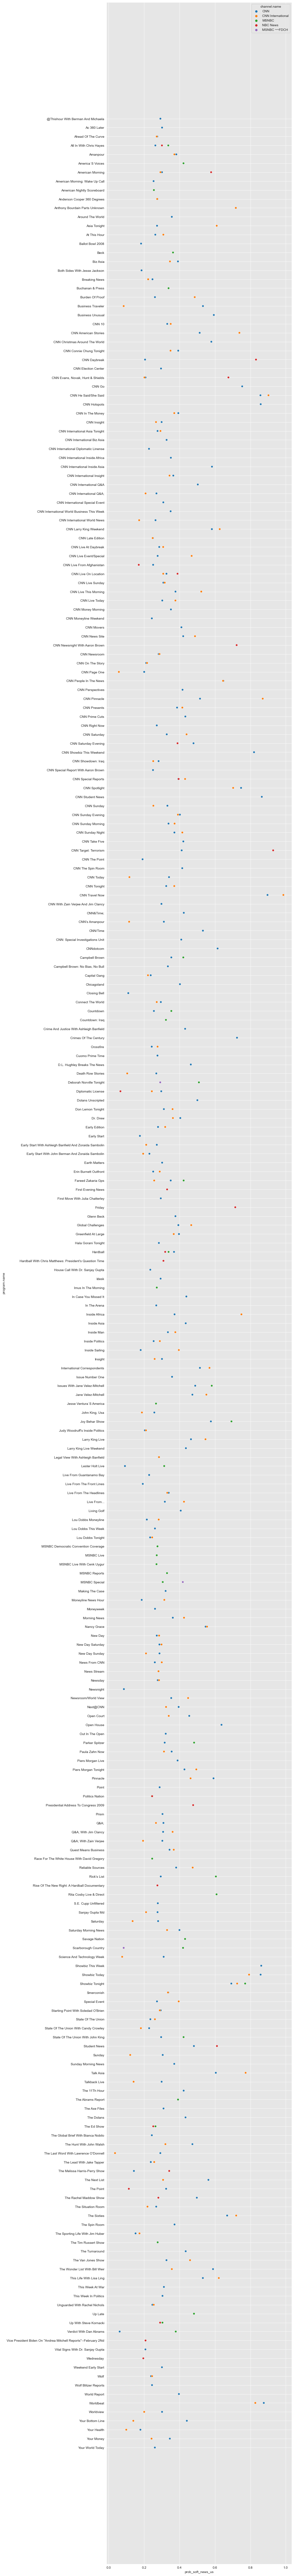

In [34]:
# Use column names of df for the different parameters x, y, color, ...

fig, ax = plt.subplots(figsize=(10,soft_news_df_grp.shape[0]/3))

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.scatterplot(x="prob_soft_news_us", y="program.name", data=soft_news_df_grp,
                      hue="channel.name", ax=ax, size_norm=.2
                )